In [1]:
# multinomial logistic regression

In [45]:
# multinomial logistic regression
# health insurance example
import pandas as pd
import numpy as np

from IPython.display import display

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss


import seaborn as sns
import matplotlib.pyplot as plt
from patsy import dmatrix

from scipy.stats import chi2


In [3]:
# multinomial logistic regression
# health insurance example

# Load the dataset
df_health = pd.read_csv("health_insurance.csv")

# Preview structure
print(df_health.shape)
print(df_health.dtypes)
display(df_health.head(10))  

(1453, 6)
product           object
age                int64
household          int64
position_level     int64
gender            object
absent             int64
dtype: object


,product,age,household,position_level,gender,absent
0,C,57,2,2,Male,10
1,A,21,7,2,Male,7
2,C,66,7,2,Male,1
3,A,36,4,2,Female,6
4,A,23,0,2,Male,11
5,A,31,5,1,Male,14
6,A,37,3,3,Male,12
7,B,37,0,3,Female,25
8,C,55,3,3,Female,3
9,B,66,2,4,Female,18


In [4]:
# multinomial logistic regression
# health insurance example

# Check for missing values in each column
print(df_health.isnull().sum())


product           0
age               0
household         0
position_level    0
gender            0
absent            0
dtype: int64


In [5]:
# multinomial logistic regression
# health insurance example

# Convert 'product' and 'gender' columns to category dtype
df_health['product'] = df_health['product'].astype('category')
df_health['gender'] = df_health['gender'].astype('category')

# Verify changes
print(df_health.dtypes)
print(df_health['product'].cat.categories)
print(df_health['gender'].cat.categories)


product           category
age                  int64
household            int64
position_level       int64
gender            category
absent               int64
dtype: object
Index(['A', 'B', 'C'], dtype='object')
Index(['Female', 'Male', 'Non-binary'], dtype='object')


In [6]:
# multinomial logistic regression
# health insurance example

# Descriptive statistics for numeric columns
print(df_health.describe())

# Value counts for categorical columns
print(df_health['product'].value_counts())
print(df_health['gender'].value_counts())


               age    household  position_level       absent
count  1453.000000  1453.000000     1453.000000  1453.000000
mean     40.918789     3.257398        2.900206    14.466621
std      13.530356     2.231402        1.216431     8.114098
min      21.000000     0.000000        1.000000     0.000000
25%      30.000000     2.000000        2.000000     8.000000
50%      37.000000     3.000000        3.000000    15.000000
75%      53.000000     5.000000        4.000000    21.000000
max      67.000000     7.000000        5.000000    31.000000
product
C    499
A    495
B    459
Name: count, dtype: int64
gender
Female        889
Male          559
Non-binary      5
Name: count, dtype: int64


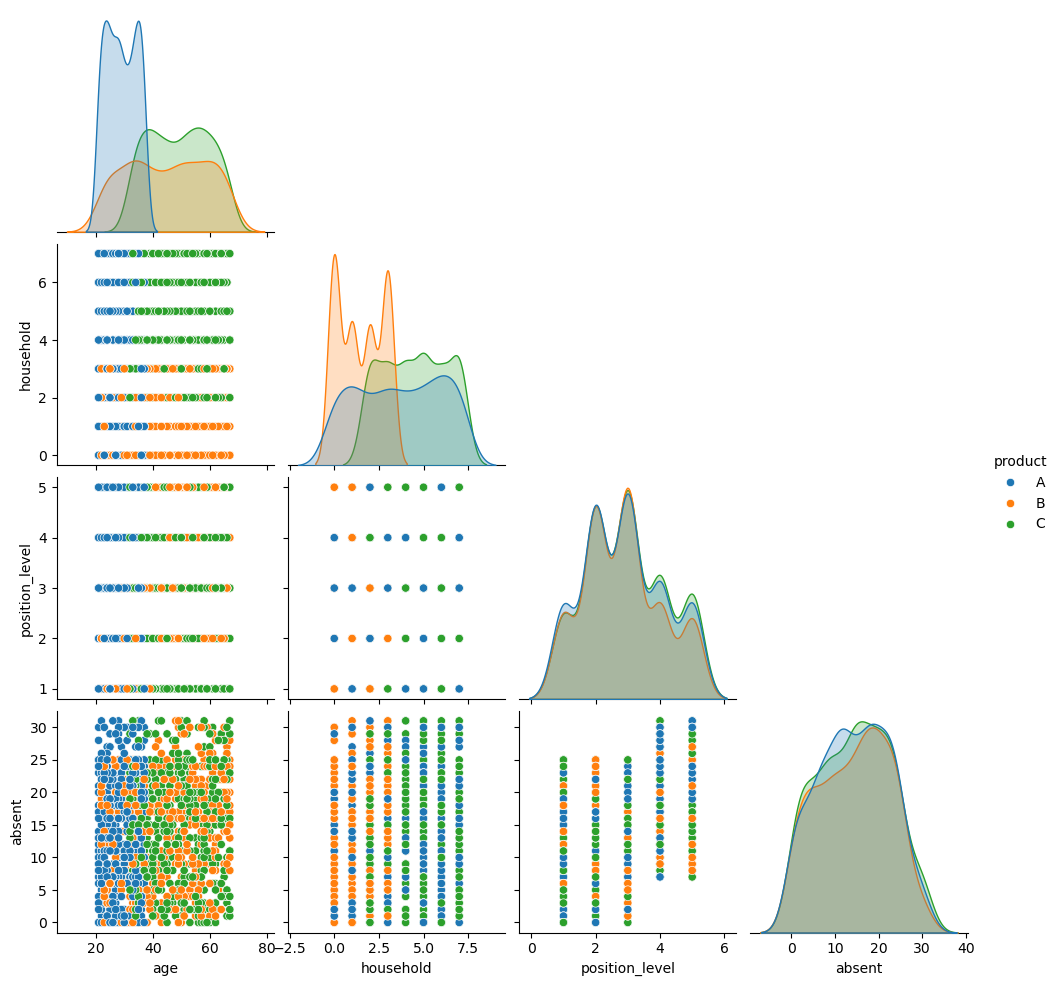

In [7]:
# multinomial logistic regression
# health insurance example


# Select numerical columns and add product for coloring
numerical_cols = ['age', 'household', 'position_level', 'absent', 'product']
sns.pairplot(df_health[numerical_cols], hue="product", diag_kind="kde", corner=True)
plt.show()


                     age  household  position_level    absent
age             1.000000   0.018280        0.151277  0.042551
household       0.018280   1.000000       -0.003217 -0.008122
position_level  0.151277  -0.003217        1.000000  0.334552
absent          0.042551  -0.008122        0.334552  1.000000


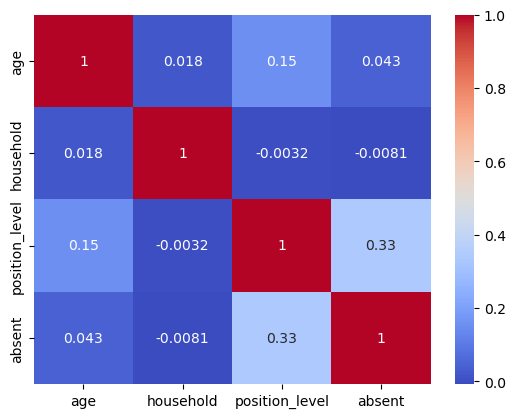

In [8]:
# multinomial logistic regression
# health insurance example

# Correlation matrix for numerical variables
corr_matrix = df_health[['age', 'household', 'position_level', 'absent']].corr()
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


In [10]:
# multinomial logistic regression
# health insurance example

# ** Run binomial logistic regression models for products A, B, and C for learning reinforcement and comparison
# Add binary columns for each product: 1 if that product, 0 otherwise
df_health['is_A'] = (df_health['product'] == 'A').astype(int)
df_health['is_B'] = (df_health['product'] == 'B').astype(int)
df_health['is_C'] = (df_health['product'] == 'C').astype(int)

In [11]:
# multinomial logistic regression
# health insurance example

# ** Run binomial logistic regression models for products A, B, and C for learning reinforcement and comparison


# 1. One-hot encode gender
X = pd.get_dummies(df_health[['age', 'household', 'position_level', 'absent', 'gender']], drop_first=True)

# 2. Add intercept
X = sm.add_constant(X)

# 3. Convert all columns to float
X = X.astype(float)

# 4. Target variable (example: is_A)
y = df_health['is_A']

# 5. Fit the logistic regression model
model_A = sm.Logit(y, X).fit()
print(model_A.summary())


Optimization terminated successfully.
         Current function value: 0.323787
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   is_A   No. Observations:                 1453
Model:                          Logit   Df Residuals:                     1446
Method:                           MLE   Df Model:                            6
Date:                Thu, 02 Oct 2025   Pseudo R-squ.:                  0.4953
Time:                        17:49:18   Log-Likelihood:                -470.46
converged:                       True   LL-Null:                       -932.07
Covariance Type:            nonrobust   LLR p-value:                3.584e-196
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 5.8736      0.453     12.963      0.000       4.986       6.762
age     

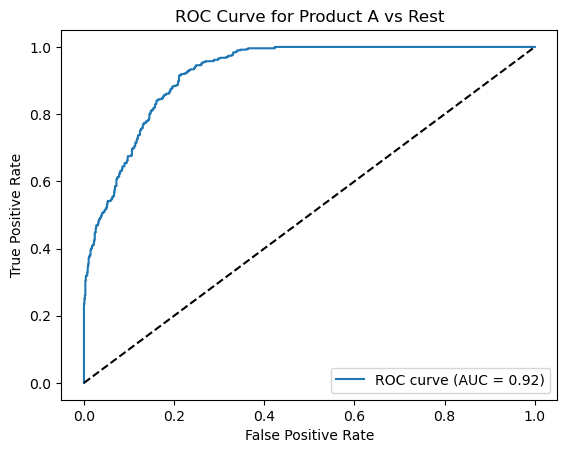

In [12]:
# multinomial logistic regression
# health insurance example

# ** Run binomial logistic regression models for products A, B, and C for learning reinforcement and comparison

# Predict probabilities for the positive class (product A)
y_pred_proba = model_A.predict(X)

# Compute ROC curve and area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Product A vs Rest')
plt.legend(loc="lower right")
plt.show()


In [13]:
# multinomial logistic regression
# health insurance example

# ** Run binomial logistic regression models for products A, B, and C for learning reinforcement and comparison
# Target variable for product B
y = df_health['is_B']

# Design matrix (reuse same predictors as before)
X = pd.get_dummies(df_health[['age', 'household', 'position_level', 'absent', 'gender']], drop_first=True)
X = sm.add_constant(X).astype(float)

# Fit logistic regression model for Product B vs Rest
model_B = sm.Logit(y, X).fit()
print(model_B.summary())


Optimization terminated successfully.
         Current function value: 0.340407
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                   is_B   No. Observations:                 1453
Model:                          Logit   Df Residuals:                     1446
Method:                           MLE   Df Model:                            6
Date:                Thu, 02 Oct 2025   Pseudo R-squ.:                  0.4542
Time:                        17:49:47   Log-Likelihood:                -494.61
converged:                       True   LL-Null:                       -906.29
Covariance Type:            nonrobust   LLR p-value:                1.379e-174
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.4591      0.318      1.443      0.149      -0.165       1.083
age     

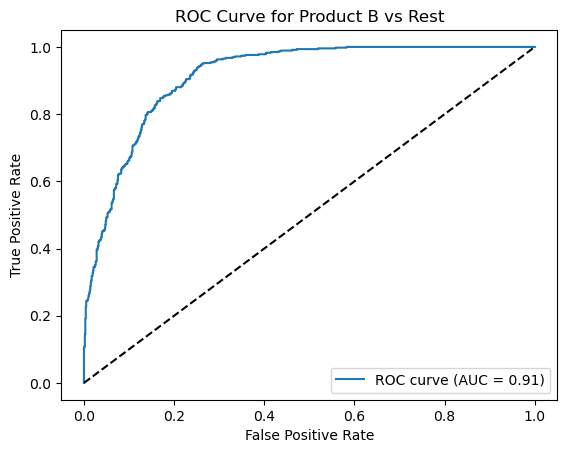

In [14]:
# multinomial logistic regression
# health insurance example

# ** Run binomial logistic regression models for products A, B, and C for learning reinforcement and comparison
# Predict probabilities for the positive class (Product B)
y_pred_proba = model_B.predict(X)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Product B vs Rest')
plt.legend(loc="lower right")
plt.show()


In [15]:
# multinomial logistic regression
# health insurance example

# ** Run binomial logistic regression models for products A, B, and C for learning reinforcement and comparison

# Target variable for product C
y = df_health['is_C']

# Design matrix (reuse same predictors)
X = pd.get_dummies(df_health[['age', 'household', 'position_level', 'absent', 'gender']], drop_first=True)
X = sm.add_constant(X).astype(float)

# Fit logistic regression model for Product C vs Rest
model_C = sm.Logit(y, X).fit()
print(model_C.summary())


Optimization terminated successfully.
         Current function value: 0.405799
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   is_C   No. Observations:                 1453
Model:                          Logit   Df Residuals:                     1446
Method:                           MLE   Df Model:                            6
Date:                Thu, 02 Oct 2025   Pseudo R-squ.:                  0.3692
Time:                        18:34:11   Log-Likelihood:                -589.63
converged:                       True   LL-Null:                       -934.69
Covariance Type:            nonrobust   LLR p-value:                8.281e-146
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -7.9348      0.454    -17.489      0.000      -8.824      -7.046
age     

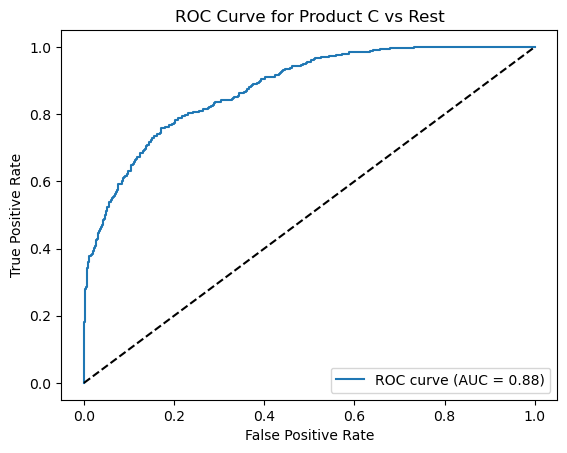

In [16]:
# multinomial logistic regression
# health insurance example

# ** Run binomial logistic regression models for products A, B, and C for learning reinforcement and comparison

# Predict probabilities
y_pred_proba = model_C.predict(X)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Product C vs Rest')
plt.legend(loc="lower right")
plt.show()


In [24]:
# multinomial logistic regression
# health insurance example

# --- multinomial logistic regression (A as reference) ---
# --- make sure 'product' is categorical and set A as the baseline (last category) ---

# ensure category order and set A as the baseline (last code)
df_health['product'] = df_health['product'].astype('category')
df_health['product'] = df_health['product'].cat.reorder_categories(['B','C','A'], ordered=True)

# 1-D coded target: B->0, C->1, A->2  (baseline = A)
y = df_health['product'].cat.codes.values

# design matrix using formula (C(gender) creates dummies; includes intercept)
X = dmatrix('1 + age + household + position_level + absent + C(gender)',
            df_health, return_type='dataframe').astype(float)

# fit multinomial logit
mn_model = sm.MNLogit(y, X).fit()
print(mn_model.summary())


Optimization terminated successfully.
         Current function value: 0.512514
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1453
Model:                        MNLogit   Df Residuals:                     1439
Method:                           MLE   Df Model:                           12
Date:                Thu, 02 Oct 2025   Pseudo R-squ.:                  0.5332
Time:                        19:06:47   Log-Likelihood:                -744.68
converged:                       True   LL-Null:                       -1595.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    y=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -5.6251      0.512    -10.995      0.000      -6.628   

In [31]:
# multinomial logistic regression
# health insurance example

# odds ratios: rows = predictors, columns = comparisons (B vs A, C vs A)
odds_ratios = np.exp(mn_model.params).copy()

# name the two columns (comparisons) correctly
odds_ratios.columns = ['B vs A', 'C vs A']

# make it neat
print(odds_ratios.round(3))
print('\n\n')

print('------view as rows------')
or_side_by_side = odds_ratios.T  # rows: B vs A, C vs A; cols: predictors
print(or_side_by_side.round(3))


                         B vs A  C vs A
Intercept                 0.004  99.585
C(gender)[T.Male]        11.933  10.833
C(gender)[T.Non-binary]   0.218   0.777
age                       1.026   0.784
household                 3.229   2.632
position_level            1.223   1.515
absent                    0.992   0.988



------view as rows------
        Intercept  C(gender)[T.Male]  C(gender)[T.Non-binary]    age  \
B vs A      0.004             11.933                    0.218  1.026   
C vs A     99.585             10.833                    0.777  0.784   

        household  position_level  absent  
B vs A      3.229           1.223   0.992  
C vs A      2.632           1.515   0.988  


In [32]:
# multinomial logistic regression
# health insurance example

# ---safely remove predictors that are statisticaly significant ---

# Refit multinomial model without 'absent' and 'gender:Non-binary'
X_reduced = dmatrix('1 + age + household + position_level + C(gender, Treatment(reference="Female"))',
                    df_health, return_type='dataframe').astype(float)

mn_model_reduced = sm.MNLogit(y, X_reduced).fit()
print(mn_model_reduced.summary())


Optimization terminated successfully.
         Current function value: 0.512818
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                 1453
Model:                        MNLogit   Df Residuals:                     1441
Method:                           MLE   Df Model:                           10
Date:                Thu, 02 Oct 2025   Pseudo R-squ.:                  0.5329
Time:                        19:23:50   Log-Likelihood:                -745.12
converged:                       True   LL-Null:                       -1595.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                   y=1       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept           

In [33]:
# multinomial logistic regression
# health insurance example

# ---safely remove predictors that are statisticaly significant ---
# --- compare coefficients: check if they change by more than ~20–25% compared to the full model ---

# Odds ratios from full vs reduced
or_full = np.exp(mn_model.params)
or_reduced = np.exp(mn_model_reduced.params)

comparison = pd.concat([or_full, or_reduced], axis=1, keys=['Full Model','Reduced Model'])
print(comparison.round(3))


                                                   Full Model          \
                                                            0       1   
Intercept                                               0.004  99.585   
C(gender)[T.Male]                                      11.933  10.833   
C(gender)[T.Non-binary]                                 0.218   0.777   
age                                                     1.026   0.784   
household                                               3.229   2.632   
position_level                                          1.223   1.515   
absent                                                  0.992   0.988   
C(gender, Treatment(reference="Female"))[T.Male]          NaN     NaN   
C(gender, Treatment(reference="Female"))[T.Non-...        NaN     NaN   

                                                   Reduced Model          
                                                               0       1  
Intercept                                     

In [35]:
# multinomial logistic regression
# health insurance example

# ---AIC (Akaike Information Criterion) ---
# a lower AIC = better trade-off between accuracy and simplicity
# only meaningful when comparing two or more models fit on the same data
# AIC balances model fit (how well the model explains the data) with model complexity (how many parameters it uses).

# Calculate the AIC score with and without the removed predictors
# AIC from a fitted multinomial model
def get_aic(model):
    k = model.df_model + 1   # +1 for intercept
    return -2 * model.llf + 2 * k

print("Full Model AIC:", get_aic(mn_model))
print("Reduced Model AIC:", get_aic(mn_model_reduced))



Full Model AIC: 1515.3647536204523
Reduced Model AIC: 1512.2480854808541


In [36]:
# multinomial logistic regression
# health insurance example

#  goodness-of-fit methods for a multinomial model
# the Hosmer–Lemeshow test (one-vs-rest) for each outcome

# ---predict class probabilities from your fitted model---

# mn_model should be your fitted statsmodels MNLogit model
probs = mn_model.predict()  # returns an array-like (n_samples x n_classes_without_baseline?) or full softmax
probs = np.asarray(probs)

# recover class labels in the same order used by your model
# earlier we ordered: ['B','C','A'] with 'A' as baseline
classes = ['B','C','A']

# put into a DataFrame for convenience
proba_df = pd.DataFrame(probs, columns=classes)
proba_df.head()


,B,C,A
0,0.266335,0.729888,0.003776
1,0.000081,0.031149,0.968770
2,0.000761,0.999070,0.000169
3,0.249092,0.356128,0.394780
4,0.109607,0.011745,0.878649


In [38]:
# multinomial logistic regression
# health insurance example

#  goodness-of-fit methods for a multinomial model
# the Hosmer–Lemeshow test (one-vs-rest) for each outcome

#  function to build the one-vs-rest Hosmer–Lemeshow (HL) test 
def hl_test_one_vs_rest(y_true_binary, y_pred_proba, g=10):
    """
    Hosmer–Lemeshow test for a binary case (one-vs-rest).
    y_true_binary: 1 if in class, 0 otherwise
    y_pred_proba: predicted probability of class membership
    g: number of groups (deciles default)
    returns: dict with statistic, df, pvalue, and a grouped table
    """
    df = pd.DataFrame({'y': y_true_binary, 'p': y_pred_proba})
    # protect against ties in quantiles: drop_duplicates on bin edges if needed
    df['group'] = pd.qcut(df['p'], q=g, duplicates='drop')
    grouped = df.groupby('group', observed=True).agg(
        n=('y','size'),
        o_pos=('y','sum'),
        p_bar=('p','mean')
    )
    grouped['e_pos'] = grouped['n'] * grouped['p_bar']
    grouped['o_neg'] = grouped['n'] - grouped['o_pos']
    grouped['e_neg'] = grouped['n'] - grouped['e_pos']

    # avoid zero-division: filter groups with tiny expected counts if necessary
    valid = (grouped['e_pos'] > 0) & (grouped['e_neg'] > 0)
    G = valid.sum()  # effective number of groups
    chi_components = ((grouped.loc[valid, 'o_pos'] - grouped.loc[valid, 'e_pos'])**2 / grouped.loc[valid, 'e_pos'] +
                      (grouped.loc[valid, 'o_neg'] - grouped.loc[valid, 'e_neg'])**2 / grouped.loc[valid, 'e_neg'])
    HL = chi_components.sum()
    df_hl = max(G - 2, 1)  # standard df is g-2; guard for small G
    pval = 1 - chi2.cdf(HL, df_hl)
    return {
        'stat': HL,
        'df': df_hl,
        'pvalue': pval,
        'table': grouped
    }


In [39]:
# multinomial logistic regression
# health insurance example

# ---how well do those probabilities match reality---

# build 1/0 indicators for each class
y_labels = df_health['product'].astype('category')
y_A = (y_labels == 'A').astype(int).values
y_B = (y_labels == 'B').astype(int).values
y_C = (y_labels == 'C').astype(int).values

# choose number of groups (deciles). if any expected counts are small, try g=8 or g=5
g = 10

hl_B = hl_test_one_vs_rest(y_B, proba_df['B'].values, g=g)
hl_C = hl_test_one_vs_rest(y_C, proba_df['C'].values, g=g)
hl_A = hl_test_one_vs_rest(y_A, proba_df['A'].values, g=g)

print(f"B vs Rest: HL stat = {hl_B['stat']:.3f}, df = {hl_B['df']}, p = {hl_B['pvalue']:.4f}")
print(f"C vs Rest: HL stat = {hl_C['stat']:.3f}, df = {hl_C['df']}, p = {hl_C['pvalue']:.4f}")
print(f"A vs Rest: HL stat = {hl_A['stat']:.3f}, df = {hl_A['df']}, p = {hl_A['pvalue']:.4f}")

# optional: inspect the grouped observed/expected table for one class
hl_B['table']


B vs Rest: HL stat = 59.949, df = 8, p = 0.0000
C vs Rest: HL stat = 29.864, df = 8, p = 0.0002
A vs Rest: HL stat = 9.086, df = 8, p = 0.3351


,n,o_pos,p_bar,e_pos,o_neg,e_neg
group,,,,,,
"(-0.0009758, 0.00201]",146,0,0.000803,0.117229,146,145.882771
"(0.00201, 0.00895]",145,0,0.004875,0.706881,145,144.293119
"(0.00895, 0.027]",145,2,0.015963,2.314599,143,142.685401
"(0.027, 0.0625]",145,8,0.042573,6.173107,137,138.826893
"(0.0625, 0.146]",146,27,0.100022,14.603196,119,131.396804
"(0.146, 0.287]",145,21,0.220004,31.900539,124,113.099461
"(0.287, 0.515]",145,75,0.409515,59.379652,70,85.620348
"(0.515, 0.728]",145,100,0.607726,88.120266,45,56.879734
"(0.728, 0.896]",145,92,0.807877,117.142118,53,27.857882


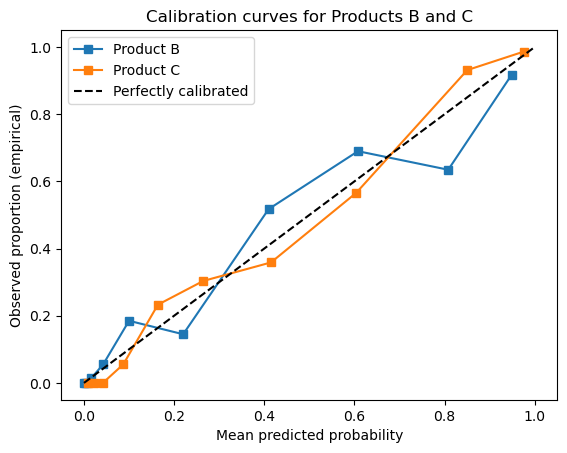

In [42]:
# multinomial logistic regression
# health insurance example

# calibration curve
# ---a calibration curve (a.k.a. reliability diagram) is the best way to visualize what the hosmer–lemeshow test was telling you numerically---

# true labels
y_labels = df_health['product'].astype('category')

# one-vs-rest indicators
y_B = (y_labels == 'B').astype(int).values
y_C = (y_labels == 'C').astype(int).values

# predicted probabilities (from proba_df)
p_B = proba_df['B'].values
p_C = proba_df['C'].values

# calibration curves
for y_true, y_pred, label in [(y_B, p_B, "Product B"),
                              (y_C, p_C, "Product C")]:
    frac_pos, mean_pred = calibration_curve(y_true, y_pred, n_bins=10, strategy='quantile')

    plt.plot(mean_pred, frac_pos, "s-", label=f"{label}")

# reference line for perfect calibration
plt.plot([0,1],[0,1],"k--", label="Perfectly calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Observed proportion (empirical)")
plt.title("Calibration curves for Products B and C")
plt.legend()
plt.show()


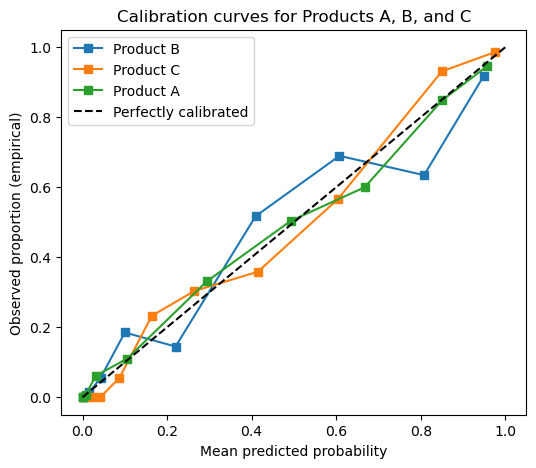

In [43]:
# multinomial logistic regression
# health insurance example

# calibration curve
# ---a calibration curve (a.k.a. reliability diagram) is the best way to visualize what the hosmer–lemeshow test was telling you numerically---

# one-vs-rest for Product A
y_A = (y_labels == 'A').astype(int).values
p_A = proba_df['A'].values

plt.figure(figsize=(6,5))

for y_true, y_pred, label in [(y_B, p_B, "Product B"),
                              (y_C, p_C, "Product C"),
                              (y_A, p_A, "Product A")]:
    frac_pos, mean_pred = calibration_curve(y_true, y_pred, n_bins=10, strategy='quantile')
    plt.plot(mean_pred, frac_pos, "s-", label=label)

plt.plot([0,1],[0,1],"k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed proportion (empirical)")
plt.title("Calibration curves for Products A, B, and C")
plt.legend()
plt.show()


In [47]:
# multinomial logistic regression
# health insurance example

# Brier Score
# a numerical measure of calibration (and overall probabilistic accuracy)
# lower is better.

# one-vs-rest true labels
y_A = (df_health['product'] == 'A').astype(int).values
y_B = (df_health['product'] == 'B').astype(int).values
y_C = (df_health['product'] == 'C').astype(int).values

# predicted probabilities
p_A = proba_df['A'].values
p_B = proba_df['B'].values
p_C = proba_df['C'].values

# compute brier scores
brier_A = brier_score_loss(y_A, p_A)
brier_B = brier_score_loss(y_B, p_B)
brier_C = brier_score_loss(y_C, p_C)


print('Even though HL test flagged B and C, the absolute Brier scores are still low.')

print("Brier Score (A):", round(brier_A, 4))
print("Brier Score (B):", round(brier_B, 4))
print("Brier Score (C):", round(brier_C, 4))




Even though HL test flagged B and C, the absolute Brier scores are still low.
Brier Score (A): 0.1036
Brier Score (B): 0.1138
Brier Score (C): 0.0989


In [49]:
# multinomial logistic regression
# health insurance example

# Brier Score
# a numerical measure of calibration (and overall probabilistic accuracy)
# lower is better.

# compute the overall multiclass Brier score (combining A, B, C)

# one-hot encode true labels
# one-hot encode true labels
y_true = pd.get_dummies(df_health['product'])[['A','B','C']].values

# predicted probabilities (ensure same order A,B,C)
y_pred = proba_df[['A','B','C']].values

# compute multiclass Brier correctly
brier_multiclass = np.mean(np.sum((y_pred - y_true)**2, axis=1))
print("Overall Multiclass Brier Score:", round(brier_multiclass, 4))


Overall Multiclass Brier Score: 0.3162


In [51]:
# multinomial logistic regression
# health insurance example

# ---null model comparison (baseline Brier score if you always predicted base rates)---

# count class frequencies
class_freq = df_health['product'].value_counts(normalize=True).sort_index()
print("Observed base rates:\n", class_freq)

# 1. Uniform null model (1/3 each class)
y_pred_uniform = np.full_like(y_pred, 1/3, dtype=float)

# 2. Base rate null model (always predict observed frequencies)
y_pred_baseline = np.tile(class_freq.values, (len(df_health), 1))

# compute Brier for each null
brier_uniform = np.mean(np.sum((y_pred_uniform - y_true)**2, axis=1))
brier_baseline = np.mean(np.sum((y_pred_baseline - y_true)**2, axis=1))

print("Null Brier (Uniform, 1/3 each):", round(brier_uniform, 4))
print("Null Brier (Observed base rates):", round(brier_baseline, 4))
print("Model Brier (Multinomial):", round(brier_multiclass, 4))


Observed base rates:
 product
B    0.315898
C    0.343427
A    0.340674
Name: proportion, dtype: float64
Null Brier (Uniform, 1/3 each): 0.6667
Null Brier (Observed base rates): 0.6676
Model Brier (Multinomial): 0.3162
Brier Skill Score (vs baseline): 0.526


In [52]:
# multinomial logistic regression
# health insurance example

# ---null model comparison (baseline Brier score if you always predicted base rates)---

# Brier Skill Score (BSS)

bss = 1 - (brier_multiclass / brier_baseline)
print("Brier Skill Score (vs baseline):", round(bss, 3))


# output
# 0.526 = 52.6% improvement over the baseline (null model that always predicts base rates).
# In other words the multinomial logistic regression reduces probability error by more than half compared to the “do nothing smart” strategy.


Brier Skill Score (vs baseline): 0.526
